In [2]:
from sched import scheduler

import torch
import torch.nn as nn


def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
       nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.1)
    )

In [3]:
class Yolo(nn.Module):
    def __init__(self, s=7,b=2, c=1):
        super(Yolo, self).__init__()
        self.s = s
        self.b = b
        self.c = c
        self.layers=[self.layer1(),self.layer2(),self.layer3(),self.layer4(), self.layer5(),self.layer6()]
        self.features = nn.Sequential(*self.layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*self.s*self.s,4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096,self.s*self.s*(self.c+self.b*5)),

        )
    def layer1(self):
        return nn.Sequential(
            conv_block(3,64,7, stride=2, padding=3),
            nn.MaxPool2d(2,2),
        )
    def layer2(self):
        return nn.Sequential(
            conv_block(64,192,3,padding=1),
            nn.MaxPool2d(2,2),
        )
    def layer3(self):
        return nn.Sequential(
            conv_block(192,128,1),
            conv_block(128,256,3, padding=1),
            conv_block(256,256,1),
            conv_block(256,512,3, padding=1),
            nn.MaxPool2d(2,2),
        )
    def layer4(self):
        blocks=[
            nn.Sequential(
                conv_block(512,256,1),
                conv_block(256,512,3, padding=1),
            ) for _ in range(4)
        ]
        return nn.Sequential(
            *blocks,
            conv_block(512,512,1),
            conv_block(512,1024,3, padding=1),
            nn.MaxPool2d(2,2)
        )
    def layer5(self):
        blocks=[
            nn.Sequential(
                conv_block(1024,512,1),
                conv_block(512,1024,3, padding=1),
            ) for _ in range(2)
        ]
        return nn.Sequential(
            *blocks,
            conv_block(1024,1024,3, padding=1),
            conv_block(1024,1024,3, stride=2, padding=1)
        )
    def layer6(self):
        return nn.Sequential(
            conv_block(1024,1024,3, padding=1),
            conv_block(1024,1024,3, padding=1)
        )
    def forward(self, x):
        x=self.features(x)
        x=self.classifier(x)
        return x.view(-1, self.s, self.s, self.c+self.b*5)

In [4]:
import torchvision.transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch

def show_prediction_on_image(model, image_path, S=7, B=2, C=1, conf_threshold=0.4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    transform = T.Compose([T.Resize((448, 448)), T.ToTensor()])

    image = Image.open(image_path).convert("RGB")
    original_w, original_h = image.size
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor).squeeze(0).cpu()

    best_conf = 0
    best_box = None
    for i in range(S):
        for j in range(S):
            cell = output[i, j]
            for b in range(B):
                conf = cell[C + b * 5]
                if conf > best_conf and conf > conf_threshold:
                    x_rel, y_rel, w_rel, h_rel = cell[C + b * 5 + 1:C + b * 5 + 5]
                    best_conf = conf
                    best_box = (j, i, x_rel, y_rel, w_rel, h_rel)

    draw = ImageDraw.Draw(image)
    if best_box:
        j, i, x_cell, y_cell, w, h = best_box
        x_center = (j + x_cell) / S * original_w
        y_center = (i + y_cell) / S * original_h
        width = w * original_w
        height = h * original_h

        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2

        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        draw.text((x1, y1 - 10), f"conf: {best_conf:.2f}", fill="red")
    else:
        print("⚠️ No se detectó ningún objeto con suficiente confianza.")

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Predicción YOLOv1 - Tumor cerebral")
    plt.show()


In [5]:
model = Yolo(s=7, b=2, c=1)  # Usa los mismos hiperparámetros del entrenamiento
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("yolotest_final.pth", map_location=device))


<All keys matched successfully>

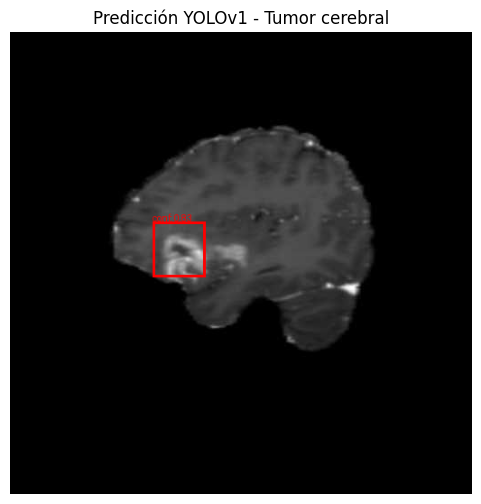

In [6]:
path_test=r"C:\Users\Intel\Desktop\yolo\brain-tumor\valid\images\val_1 (1).jpg"
show_prediction_on_image(model,path_test)